In [1]:
import os
import gdown
import sys
import torch
from data import prepare_dataloaders
import numpy as np

import matplotlib.pyplot as plt

sys.path.append('PyTorch-VAE')
from models import HVAE, LVAE, SWAE

In [2]:
if not os.path.exists('./Data'):
    gdown.download('https://drive.google.com/uc?id=1Fl-YuaKx0Gh7vcDHBWsKmSLhBgJFRUpH', 'img_align_celeba.zip', quiet=True)
    !unzip -q img_align_celeba

In [3]:
device = 'cuda:0'

vae_models = {'HVAE': HVAE,
              'LVAE': LVAE,
              'SWAE': SWAE}

config = {}
config['HVAE'] = {
    'model_params': {
        'name': 'HVAE',
        'in_channels': 3,
        'latent1_dim': 64,
        'latent2_dim': 64,
        'pseudo_input_size': 128
    },
    'data_params': {
        'root': "Data/",
        'batch_size': 32,
        'patch_size': 64,
        'num_workers': 2,
        'pin_memory':True
    },
    'exp_params': {
        'LR': 0.0005,
        'weight_decay': 0.0,
        'scheduler_gamma': 0.95,
        'manual_seed': 1265
    },
    'trainer_params': {
        'max_epochs': 10,
        'patience': 2,
        'best_path': "best_swae",
        'kld_weight': 0.00025
    },
    'logging_params': {
        'save_dir': "logs/",
        'name': "VampVAE"
    }
}

config['LVAE'] = {
    'model_params': {
        'name': 'LVAE',
        'in_channels': 3,
        'latent_dims': [4, 8, 16, 32, 128],
        'hidden_dims': [32, 64, 128, 256, 512]
    },
    'data_params': {
        'root': "Data/",
        'batch_size': 32,
        'patch_size': 64,
        'num_workers': 2,
        'pin_memory':True
    },
    'exp_params': {
        'LR': 0.0005,
        'weight_decay': 0.0,
        'scheduler_gamma': 0.95,
        'manual_seed': 1265
    },
    'trainer_params': {
        'max_epochs': 10,
        'patience': 2,
        'best_path': "best_swae",
        'kld_weight': 0.00025
    },
    'logging_params': {
        'save_dir': "logs/",
        'name': "LVAE"
    }
}

config['SWAE'] = {
    'model_params': {
        'name': 'SWAE',
        'in_channels': 3,
        'latent_dim': 128,
        'reg_weight': 100,
        'wasserstein_deg': 2.0,
        'num_projections': 200,
        'projection_dist': "normal"  # "cauchy"
    },
    'data_params': {
        'root': "Data/",
        'batch_size': 32,
        'patch_size': 64,
        'num_workers': 2,
        'pin_memory':True
    },
    'exp_params': {
        'LR': 0.0005,
        'weight_decay': 0.0,
        'scheduler_gamma': 0.95,
        'manual_seed': 1265
    },
    'trainer_params': {
        'max_epochs': 10,
        'patience': 2,
        'best_path': "best_swae",
        'kld_weight': 0.00025,
    },
    'logging_params': {
        'save_dir': "logs/",
        'name': "SWAE"
    }
}

In [4]:
def train(model, train_loader, val_loader, optimizer, config):
    model.train()
    best_epoch = 0
    best_loss = np.inf

    patience = config['patience']
    max_epochs = config['max_epochs']
    kld = config['kld_weight']
          
    for epoch in range(max_epochs):
        total_loss = 0.0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            results = model(data, labels = labels)
            loss_dict = model.loss_function(*results, M_N = kld)
            loss = loss_dict['loss']
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch + 1} Average train loss: {avg_loss:.6f}')

        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                results = model(data, labels = labels)
                loss_dict = model.loss_function(*results, M_N = kld)
                val_loss += loss_dict['loss'].item()
                
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f'====> Epoch: {epoch + 1} Average validation loss: {avg_val_loss:.6f}')

        if avg_val_loss < best_loss:
            best_epoch = epoch
            best_loss = avg_val_loss
            torch.save(model.state_dict(), config['best_path'])
            print(f'Saved model at epoch {epoch + 1}')

        if epoch - best_epoch > patience:
            print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
            break
            
        model.train()

    print("Training finished.")

In [5]:
model = HVAE(**config['HVAE']['model_params']).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = config['HVAE']['exp_params']['LR'], weight_decay=config['HVAE']['exp_params']['weight_decay'])
train_loader, val_loader, test_loader = prepare_dataloaders(**config['HVAE']['data_params'])

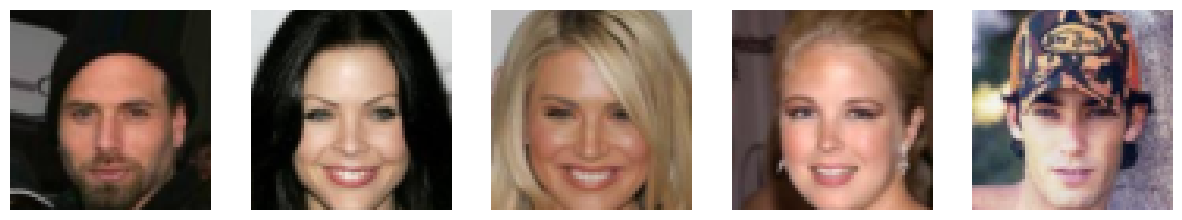

In [6]:
def sample_images(dataloader, n=5):
    images, _ = next(iter(dataloader))

    sampled_images = images[:n]

    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    for i in range(n):
        image = sampled_images[i]
        image = image.permute(1, 2, 0)
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

sample_images(train_loader, 5)

In [7]:
train(model, train_loader, val_loader, optimizer, config['HVAE']['trainer_params'])

KeyboardInterrupt: 